## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_InitialDoE_Feb.csv', firstRow=108, lastRow=114)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_030223_S109-114.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)

## Analyse water addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=64s and ended at t=476s; mass=44.87395000000001g
This equals a volume of 44.964m; expected was 45.514mL; error is 1.209%


## Analyise surfactants

Peak threshold for 1st derivative = 0.001 g/s and for 2nd derivative = 0.0002 g/s^2


<IPython.core.display.Javascript object>


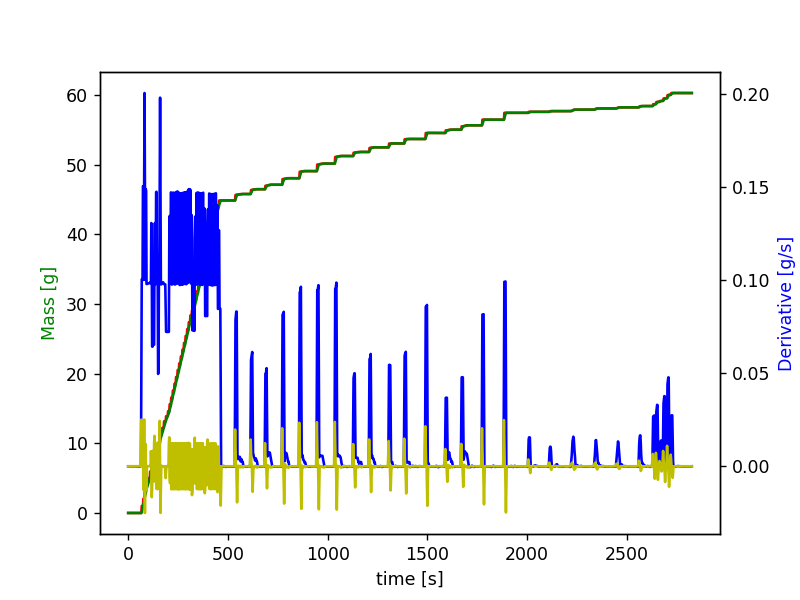

Addition of 0.931g Plantacare 818 detected from 532s to 582s - expected volume = 0.5mL and actual volume = 0.862mL (resulting error is 72.315%)
Addition of 0.692g Plantacare 818 detected from 610s to 654s - expected volume = 0.5mL and actual volume = 0.641mL (resulting error is 28.185%)
Addition of 0.648g Plantacare 818 detected from 682s to 726s - expected volume = 0.504mL and actual volume = 0.599mL (resulting error is 18.862%)
Addition of 0.937g Plantacare 818 detected from 768s to 812s - expected volume = 0.504mL and actual volume = 0.866mL (resulting error is 72.0%)
Addition of 1.028g Plantacare 818 detected from 854s to 896s - expected volume = 0.864mL and actual volume = 0.945mL (resulting error is 9.415%)
Addition of 1.085g Plantacare 818 detected from 942s to 988s - expected volume = 0.885mL and actual volume = 1.0mL (resulting error is 13.062%)
Addition of 1.091g Plantacare 818 detected from 1032s to 1078s - expected volume = 0.953mL and actual volume = 0.999mL (resulting err

In [3]:
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant',steps=steps,start_idx=t1,show=True)

## Analyse polyelectrolytes

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.00025 g/s^2


<IPython.core.display.Javascript object>


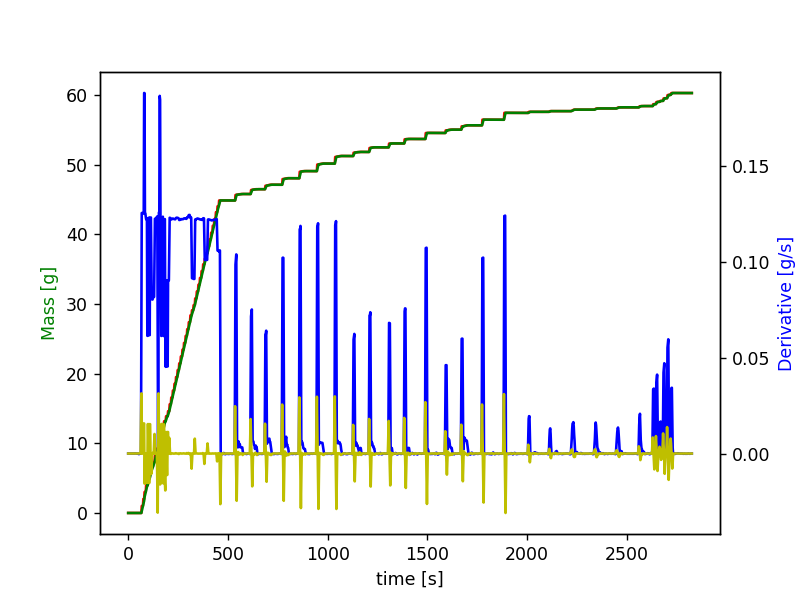

Addition of 0.102g Luviquat Excellence detected from 2106s to 2126s - expected volume = 0.165mL and actual volume = 0.093mL (resulting error is 43.403%)
Erroneously detected peak from 2140s to 2154s - but detected mass change was smaller than defined minimum of 0.01 g
Addition of 0.213g Luviquat Excellence detected from 2216s to 2246s - expected volume = 0.1mL and actual volume = 0.194mL (resulting error is 93.636%)
Addition of 0.169g Luviquat Excellence detected from 2332s to 2362s - expected volume = 0.209mL and actual volume = 0.154mL (resulting error is 26.413%)
Addition of 0.166g Luviquat Excellence detected from 2442s to 2480s - expected volume = 0.146mL and actual volume = 0.151mL (resulting error is 3.672%)
Addition of 0.189g Luviquat Excellence detected from 2556s to 2592s - expected volume = 0.145mL and actual volume = 0.171mL (resulting error is 18.125%)
Addition of 1.872g Luviquat Excellence detected from 2626s to 2736s - expected volume = 0.163mL and actual volume = 1.699m

In [4]:
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=6, mergeSens=6, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.0011250000000000001 g/s^2


<IPython.core.display.Javascript object>


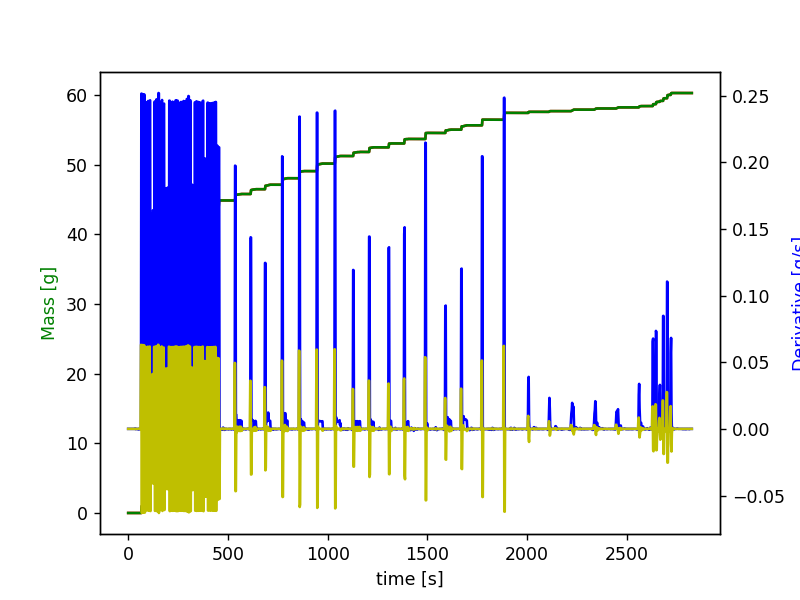

StopIteration: 

In [5]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=9, mergeSens=2, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [ ]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_S115-S120.csv', index=False)
actualMassFractions